# Google Play Store 리뷰 크롤링을 통한 데이터 분석

- 목적 : 어플리케이션 리뷰를 분석하여 인사이트 도출
- 대상 : 4가지 국내 음원 스트리밍 서비스 어플리케이션(Melon, Gini, Bugs, Vibe)
- 데이터 수집방법 : Google Play Store 리뷰 크롤링
- 데이터 (2020년 1월 1일 ~ 2020년 3월 18일)
    - Melon : 1164개
    - Gini : 484개
    - Bugs : 204개
    - Vibe : 844개

In [1]:
import pandas as pd
import re
from bs4 import BeautifulSoup
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic' # 글씨체
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import warnings
import numpy as np

warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
df_melon = pd.read_json("melon_review.json")
df_gini = pd.read_json("gini_review.json")
df_bugs = pd.read_json("bugs_review.json")
df_vibe = pd.read_json("vibe_review.json")

df_list = [df_melon, df_gini, df_bugs, df_vibe]
df_name_list = ['melon', 'gini', 'bugs', 'vibe']

p = re.compile(r'\d+') # 숫자만 들고와
def parser(body):
    bs = BeautifulSoup(body, 'html.parser')
    date = bs.find('span', class_='p2TkOb').text
    rating = bs.find('div', {'role':'img'})['aria-label']
    rating = p.findall(rating)[-1]
    review_text = bs.find('span', {'jsname':'bN97Pc'}).text
    return date, int(rating), review_text

In [3]:
for i, df in enumerate(df_list) :
    df['date'], df['rating'], df['review_text'] = zip(*df['body'].map(parser)) 
    df['date'] = pd.to_datetime(df['date'], format='%Y년 %m월 %d일') # convert to datetime format
    df['month'] = df['date'].apply(lambda x: x.month) # add month data
    del df['body']
    # df = df[df['date'] > datetime(2019,12,32)] 는 적용이 안됨
    df.drop(df[df['date'] < datetime(2020, 1, 1)].index, inplace=True) # 2020년도 data만 사용
    df['company'] = df_name_list[i]

- 크롤링 해온 json파일을 불러와 핸들링 할 수 있게끔, DataFrame 형태로 만들어 준다.
- 후에 각각의 DataFrame을 하나로 합쳐 다루기 좋게 만들어 준다.

In [4]:
df_all = pd.concat([df_melon, df_gini, df_bugs, df_vibe])

In [6]:
# review 전처리
df_all = df_all.dropna(how = 'any') # Null 값이 존재하는 행 제거
df_all['review_text'] = df_all['review_text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식을 통한 한글 외 문자 제거
df_all['review_text'] = df_all['review_text'].map(lambda x : x.strip()) # 스페이스 공백으로 채워져있는 있는 내용 제거 
df_all = df_all[df_all['review_text'] != ''] # 위에서 한글 외 문자 제거를 하면서 ''인 내용들이 생기거나 원래 ''인 내용들 제거

- 리뷰를 한글 외 데이터 없애기, 비어있는 행 삭제 등 전처리를 해준다

In [7]:
df_all

,date,rating,review_text,month,company
0,2020-03-15,1,별 한 개 주기도 아깝네요 제가 산 노래로 스트리밍 하겠다는데 그것 조차 이용권을...,3,melon
1,2020-03-16,4,플레이리스트를 한 번 더 묶어 분류할 수 있다면 정말 편할 것 같아요 가수별로 분류...,3,melon
2,2020-03-14,2,앱에 들어가도 제일 기본인 홈화면만 나오고 플레이리스트나 다른 부분 누르면 다 튕겨...,3,melon
3,2020-03-15,1,처음 구매할때 개월 원 으로 구매했거든요 근데 달 조금 넘었을때 갑자기 분 듣기로 ...,3,melon
4,2020-03-18,2,사용하기힘듬 왜쓰는지 모르겠다 노래가 많은것도 아님 팝송국내음악 제외하고는 없음 걍...,3,melon
...,...,...,...,...,...
800,2020-01-01,1,별하나도 아까워요 너무불편하고 전에 네이버뮤직 잘썼는데 갑자기 바뀌더니다른 앱으로 ...,1,vibe
801,2020-01-01,5,노래음질이 제일 좋았어요,1,vibe
802,2020-01-01,5,조쿠먄요,1,vibe
803,2020-01-01,5,너무 감사해요 이런앱 만들어 주신 분들 감사합니다,1,vibe


Text(0.5, 0.98, '월 별 별점 수')

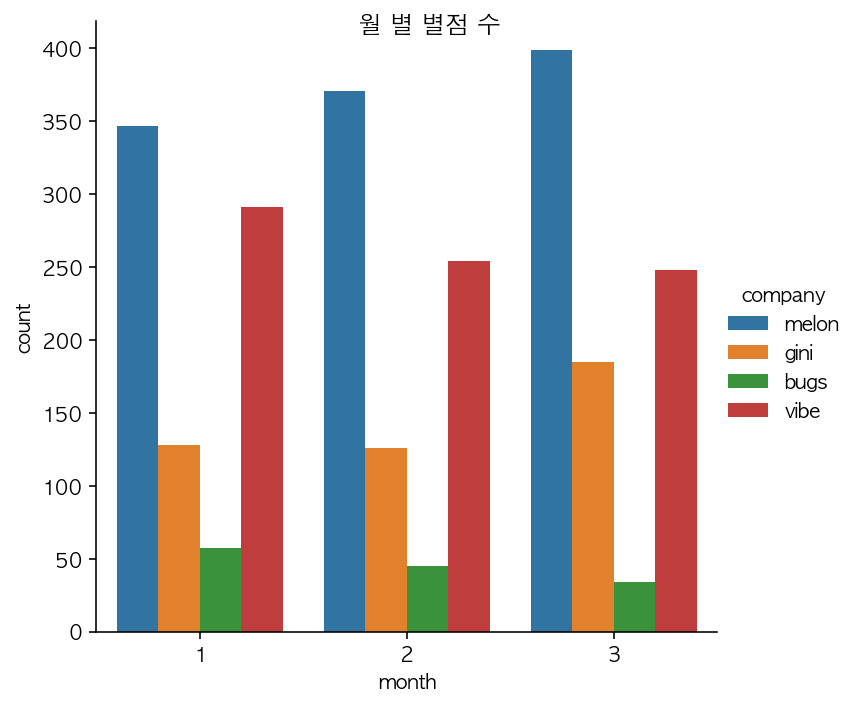

In [8]:
sns.catplot('month',kind='count',hue='company',data=df_all)
plt.suptitle('월 별 별점 수')

Text(0.5, 0.98, '2020년 월 별 <리뷰 수> 경쟁사별 비교')

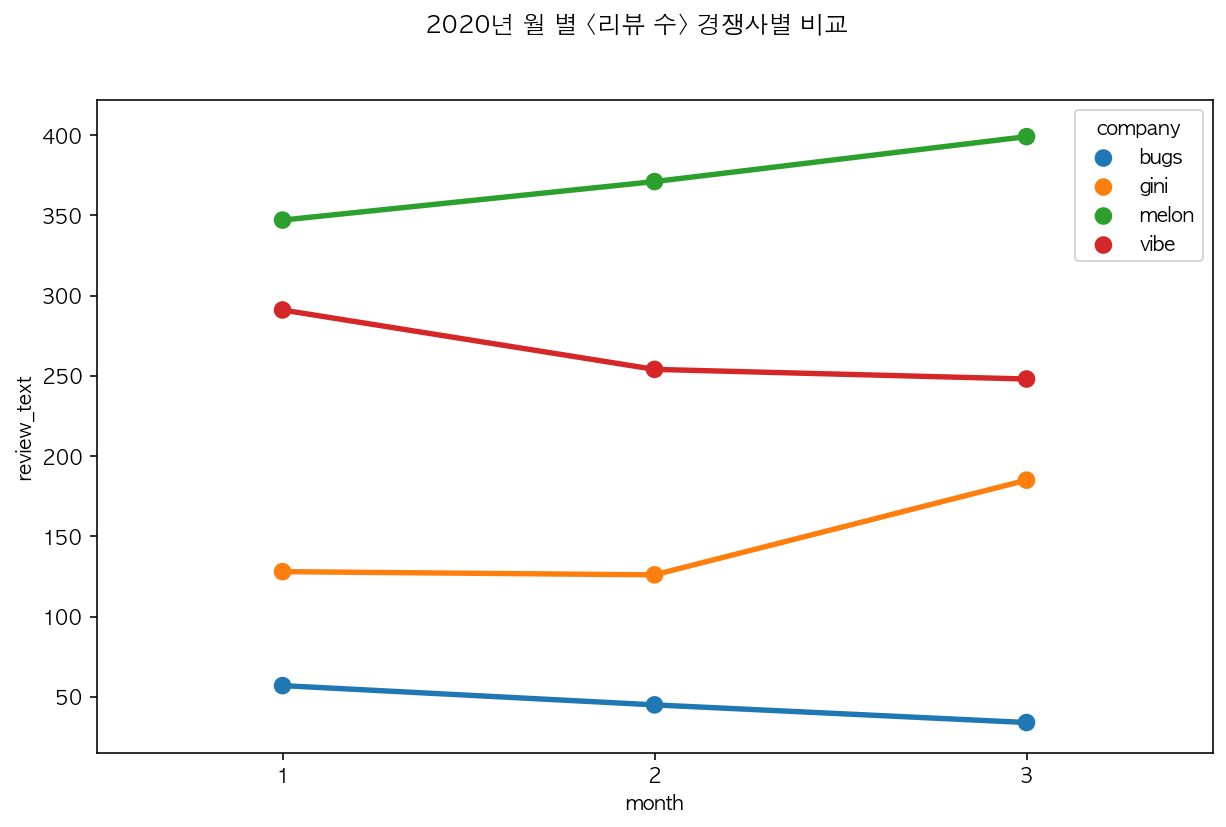

In [9]:
# 경쟁사별 리뷰 수 비교
plt.figure(figsize=(10, 6))
t1 = pd.pivot_table(data=df_all, index=['company','month'], values='review_text', aggfunc='count').reset_index()
sns.pointplot(data=t1, x='month', y='review_text', hue='company')
plt.suptitle('2020년 월 별 <리뷰 수> 경쟁사별 비교')
# 리뷰수는 melon이 1위이고 vibe는 그 다음을 잇는다.

Text(0.5, 0.98, '2020년 월 별 <평균 평점> 경쟁사별 비교')

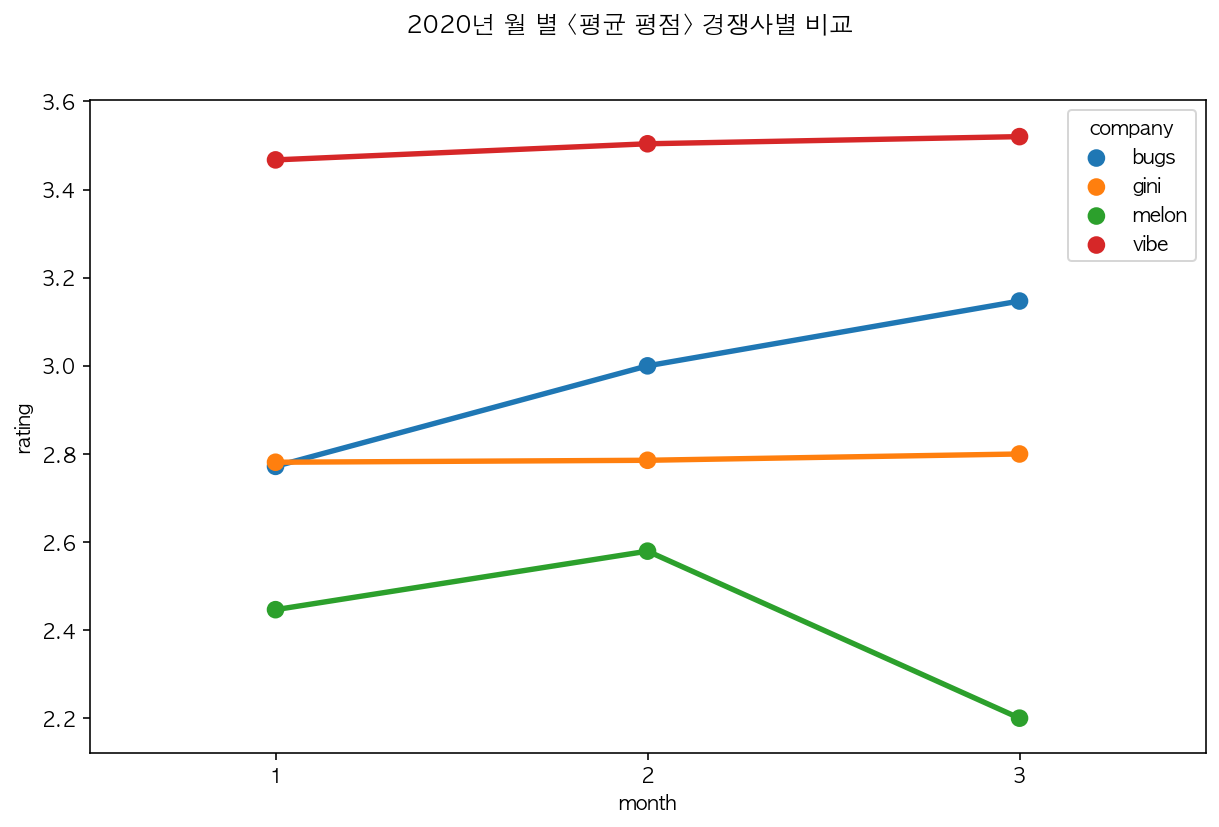

In [10]:
plt.figure(figsize=(10, 6))
t2 = pd.pivot_table(data=df_all, index=['company','month'], values='rating', aggfunc='mean').reset_index()
sns.pointplot(data=t2, x='month', y='rating', hue='company')
plt.suptitle('2020년 월 별 <평균 평점> 경쟁사별 비교')

- 경쟁사 중 Vibe의 평균 평점이 가장 높다.
- Bugs의 평균 평점은 소폭 상승하고 있다.
- melon의 경우 3월에 큰 폭으로 하락하는 것을 볼 수 있다.
- 왜 급락할까?
- 좀 더 자세히 알아보기 위해 일별로 확인해보자.

Text(0.5, 0.98, '2020년 일 별 <리뷰 수> 경쟁사별 비교')

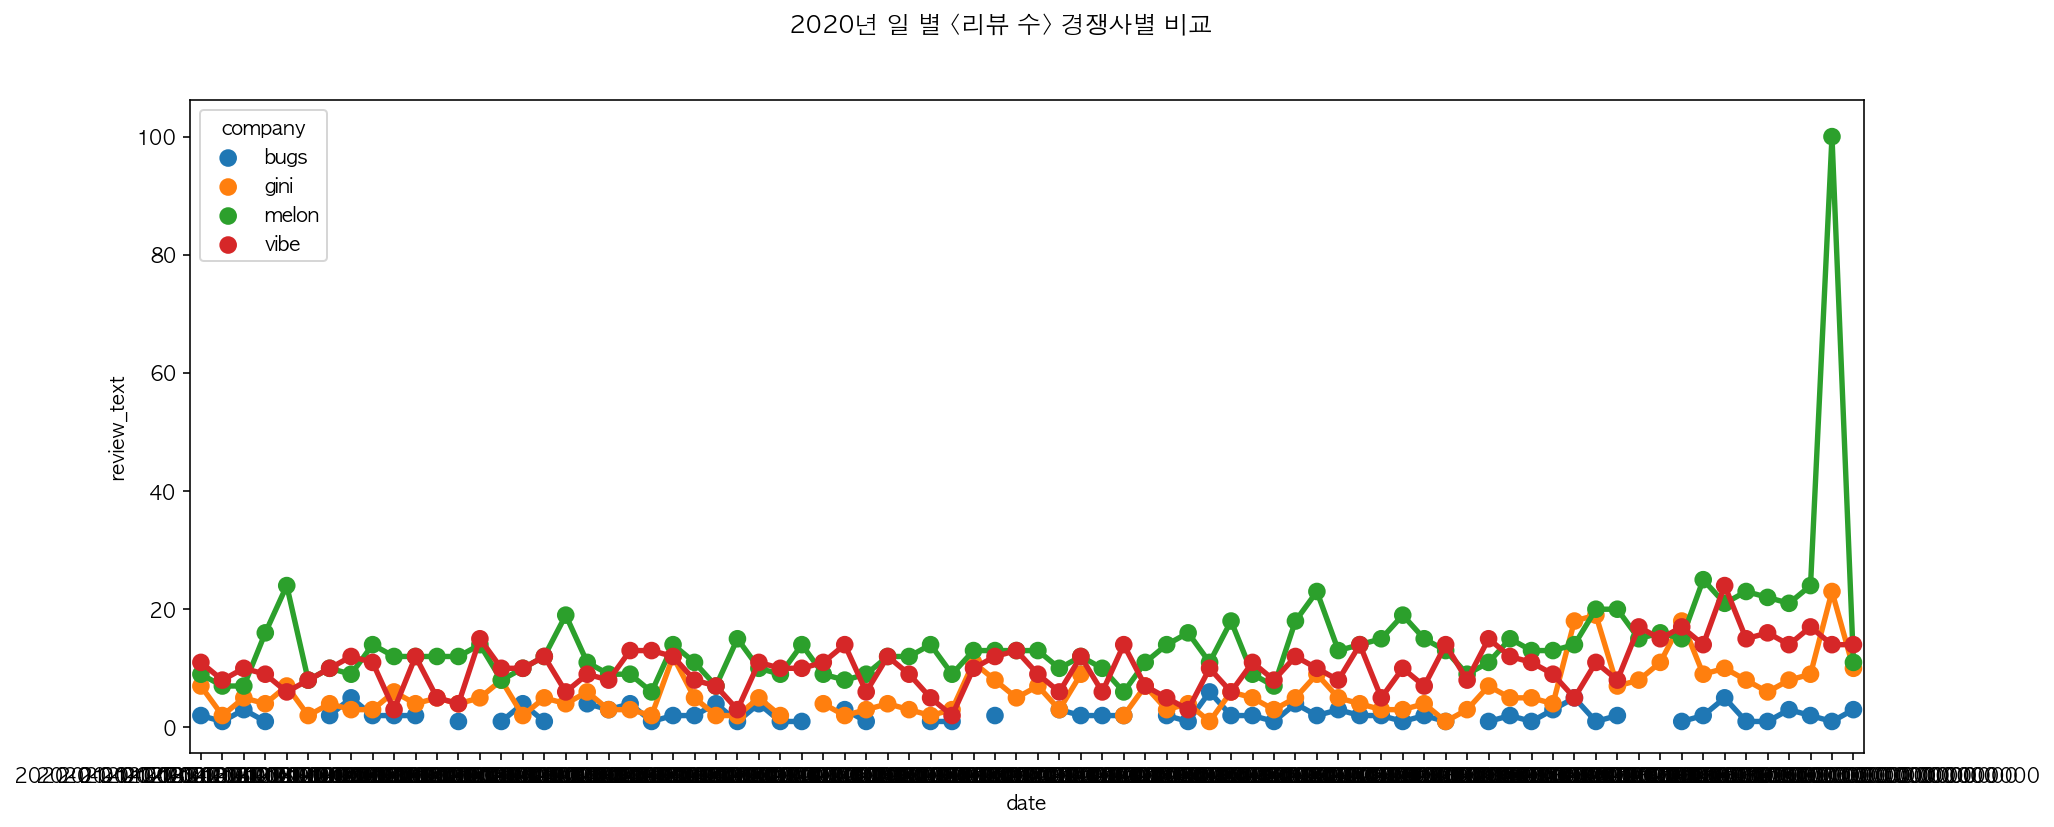

In [11]:
plt.figure(figsize=(15, 6))
t1 = pd.pivot_table(data=df_all, index=['company','date'], values='review_text', aggfunc='count').reset_index()
sns.pointplot(data=t1, x='date', y='review_text', hue='company')
plt.suptitle('2020년 일 별 <리뷰 수> 경쟁사별 비교')

- 확인 결과 melon에서 특정 날의 리뷰수가 이상하게 높은 것을 확인.
- 좀 더 자세히 보기 위해 3월 이후 데이터에 대해서만 확인해보자.

215   2020-03-17
Name: date, dtype: datetime64[ns]


Text(0.5, 0.98, '2020년 3월 <리뷰 수> 경쟁사별 비교')

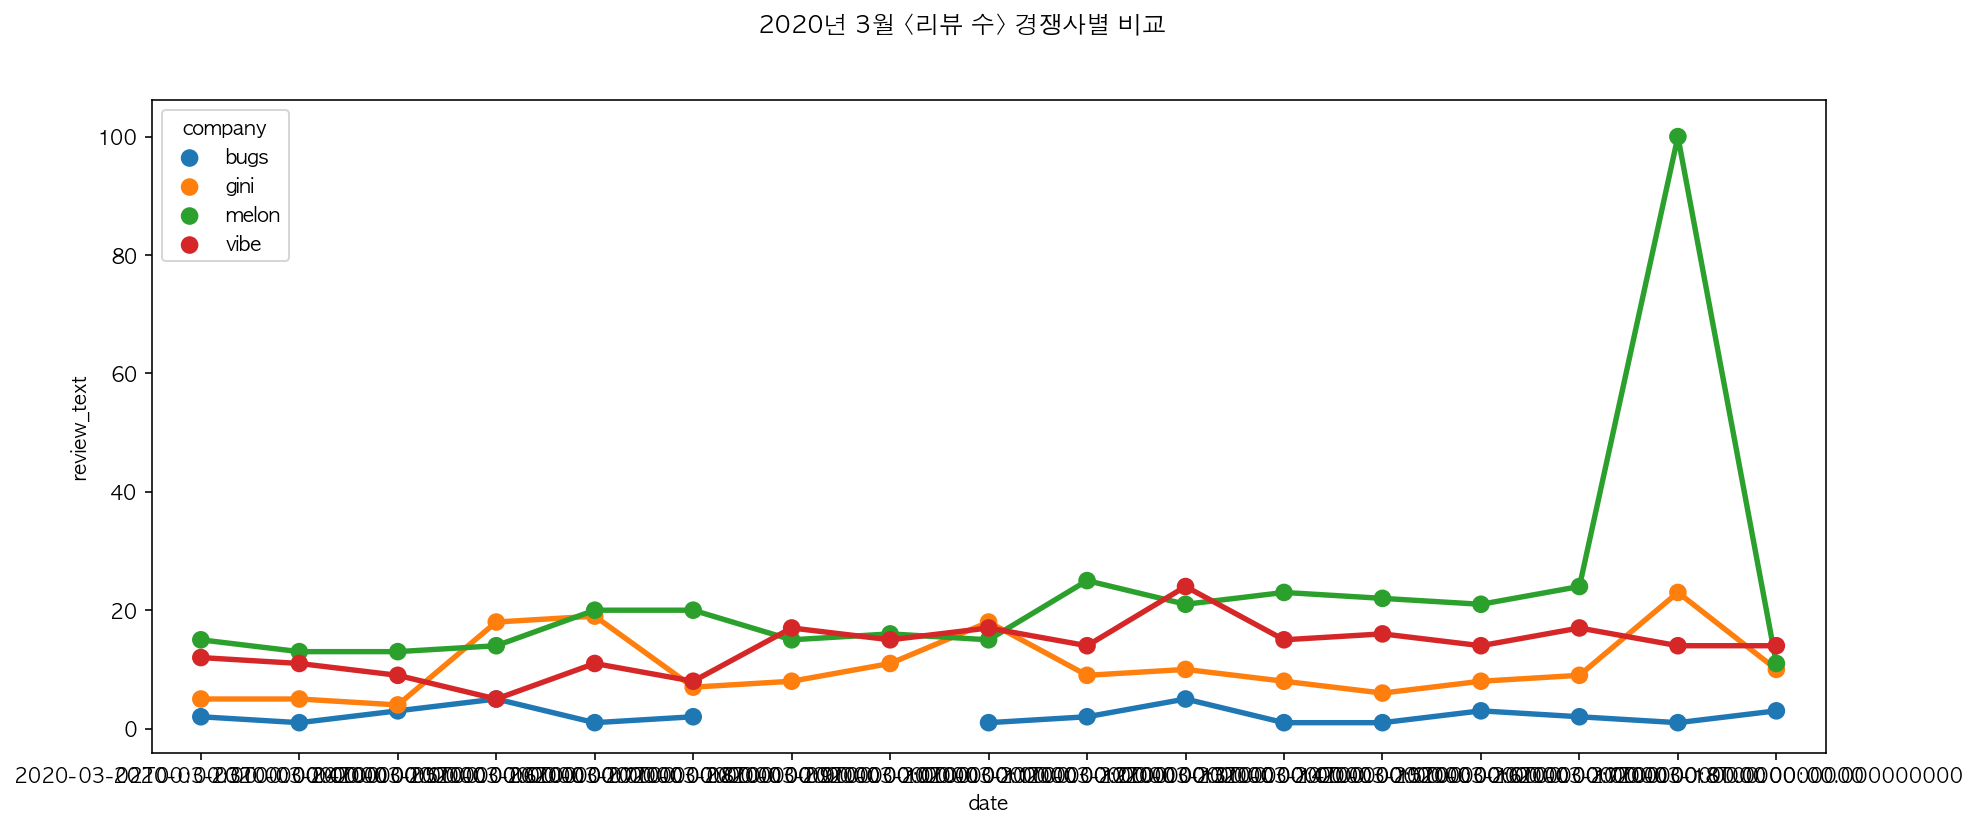

In [12]:
plt.figure(figsize=(15, 6))
t1 = t1[t1['date'] > datetime(2020,3,1)]
print(t1[t1['review_text'] > 80]['date'])
sns.pointplot(data=t1, x='date', y='review_text', hue='company')
plt.suptitle('2020년 3월 <리뷰 수> 경쟁사별 비교')

- review수가 80이상인 날을 확인했을 때, 이상치가 나타난 날이 3월 17일 이란 것을 확인할 수 있다.

In [13]:
t2 = df_all[(df_all['date']==datetime(2020,3,17)) & (df_all['company']=='melon')]
t2_rating_reviewcount = pd.pivot_table(data=t2, index=['rating'], values='review_text', aggfunc='count')
t2_rating_reviewcount['ratio'] = t2_rating_reviewcount['review_text']/sum(t2_rating_reviewcount['review_text']) * 100
t2_rating_reviewcount['ratio'] = t2_rating_reviewcount['ratio'].apply(lambda x : str(int(x))+'%')
t2_rating_reviewcount

,review_text,ratio
rating,,
1,75,75%
2,11,11%
3,7,7%
4,3,3%
5,4,4%


- 3/17일의 Melon review의 평점을 보면 1점이 75%로 대부분을 차지하고 있는 것을 확인 할 수 있다.
- 어떤 이슈가 있었던 걸까?
- WordCloud를 활용하여 그날 리뷰에서 등장한 단어들의 분포를 보자.

In [177]:
okt = Okt()

def get_word_low_rating(sentence):
    nouns = okt.nouns(sentence)
    return [noun for noun in nouns if len(noun) > 1]

countvector = CountVectorizer(tokenizer=get_word_low_rating, max_features=300)
tdf = countvector.fit_transform(t2['review_text'])
words = countvector.get_feature_names()
count_mat = tdf.sum(axis=0)
count = np.squeeze(np.asarray(count_mat))
word_count = list(zip(words, count))
word_count = sorted(word_count, key=lambda t:t[1], reverse=True)

In [190]:
word_count[:10]

[('로그인', 89),
 ('계속', 28),
 ('오류', 26),
 ('갑자기', 24),
 ('노래', 24),
 ('로그아웃', 16),
 ('재생', 14),
 ('멜론', 13),
 ('다시', 12),
 ('진짜', 10)]

- Konlpy를 이용하여 토큰화를 하여 가장 많이 나온 명사를 보면, 로그인 관련 문제임을 알 수 있다.
- WordCloud를 이용해 시각화 해보자.

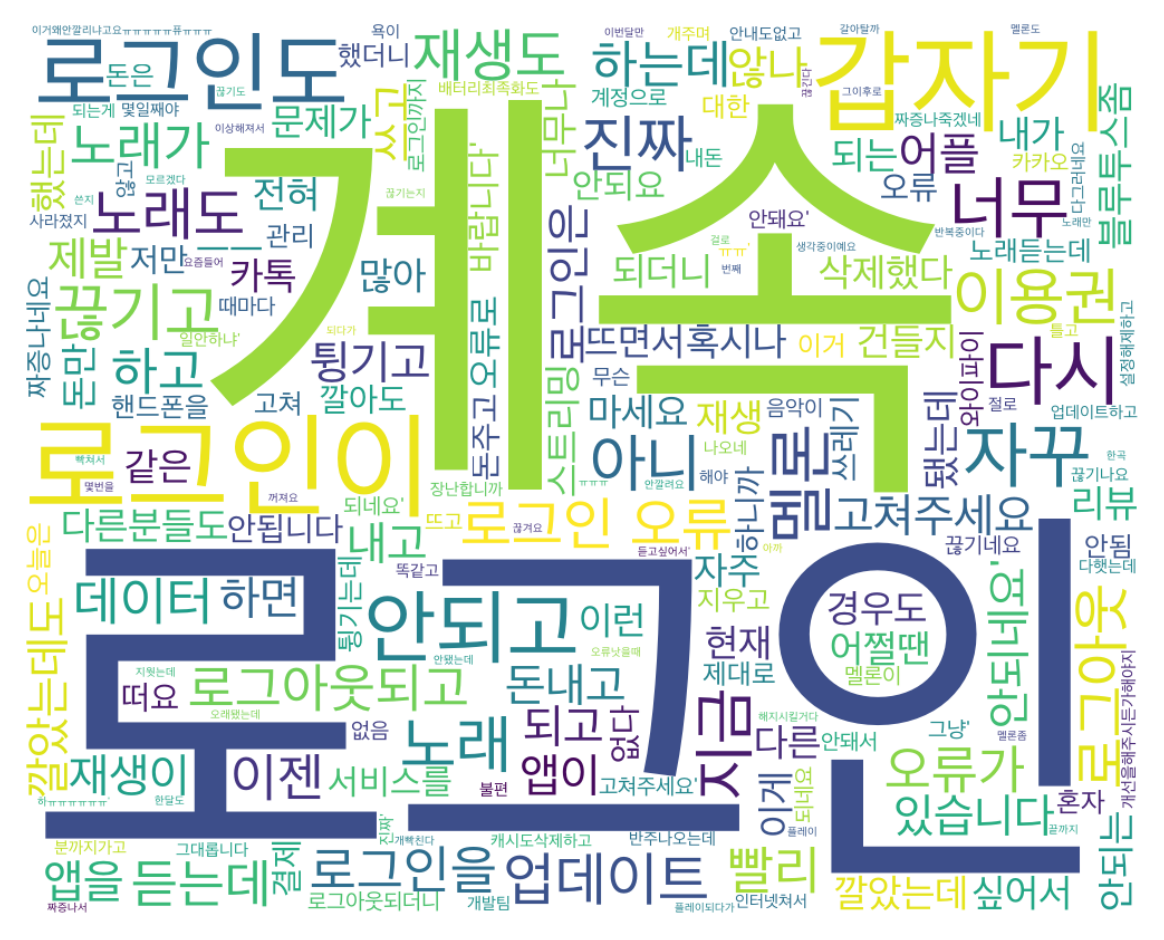

In [14]:
font_path = '/System/Library/Fonts/AppleSDGothicNeo.ttc'
wc = WordCloud(width = 1000, height = 800, background_color="white", font_path=font_path).generate(np.array2string(t2['review_text'].values))
plt.figure(figsize=(6, 5), dpi=120)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

- WordCloud를 이용해 시각화를 해본 결과
- 3/17 melon에서 로그인 문제가 발생한 하여 부정적인 리뷰수가 급증한 것을 확인 할 수 있다.

## 리뷰특징 정리
- 대부분 좋아서 리뷰를 작성하기 보다는 특정 이슈가 있을 때 작성하는 경우 많음